
<center style='color:Blue'><h2>DSCI_6011_02 DEEP LEARNING</h2></center>
 
<center><h3>Early Detection of Plant Diseases Using Medical Imaging Data</h3></center>
 
<center><h4 style='color:red'>Submitted Under the guidance of Professor Mr. Khaled Sayed</h4></center>

<center>
    <font size='2'>
        <br>Kaja Hema Sai
        <br>Venkata Sivannarayana Pavuluri
    </font>
</center>



# 1.Model: Using a Pretrained Model resnet18 and rice_leaf_diseases Dataset

In [60]:
import torch
import warnings
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



# Suppress deprecated warnings from torchvision
warnings.filterwarnings("ignore", category=UserWarning)


In [61]:
# Define data transformation pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.RandomRotation(degrees=30),  # Apply random rotation
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomVerticalFlip(),  # Apply random vertical flip
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Apply random affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Define dataset
dataset = datasets.ImageFolder(root='rice_leaf_diseases', transform=data_transform)

# Define dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [62]:
# Check number of classes
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)


Number of classes: 3


In [63]:
# Define data transformation pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='rice_leaf_diseases', transform=data_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [64]:
# Define the model architecture
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # Output layer with 3 classes

In [65]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {100*train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_accuracy:.2f}%")
    
    # Save losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/10, Train Loss: 1.0800, Train Acc: 39.58%, Val Loss: 0.5828, Val Acc: 83.33%
Epoch 2/10, Train Loss: 0.4104, Train Acc: 84.38%, Val Loss: 7.9869, Val Acc: 41.67%
Epoch 3/10, Train Loss: 0.2921, Train Acc: 90.62%, Val Loss: 12.5509, Val Acc: 45.83%
Epoch 4/10, Train Loss: 0.3123, Train Acc: 92.71%, Val Loss: 10.0931, Val Acc: 45.83%
Epoch 5/10, Train Loss: 0.3859, Train Acc: 88.54%, Val Loss: 14.5488, Val Acc: 62.50%
Epoch 6/10, Train Loss: 0.1658, Train Acc: 93.75%, Val Loss: 14.5800, Val Acc: 45.83%
Epoch 7/10, Train Loss: 0.0823, Train Acc: 96.88%, Val Loss: 8.0173, Val Acc: 58.33%
Epoch 8/10, Train Loss: 0.1215, Train Acc: 93.75%, Val Loss: 2.7123, Val Acc: 70.83%
Epoch 9/10, Train Loss: 0.0576, Train Acc: 98.96%, Val Loss: 0.8262, Val Acc: 83.33%
Epoch 10/10, Train Loss: 0.0550, Train Acc: 97.92%, Val Loss: 0.0115, Val Acc: 100.00%


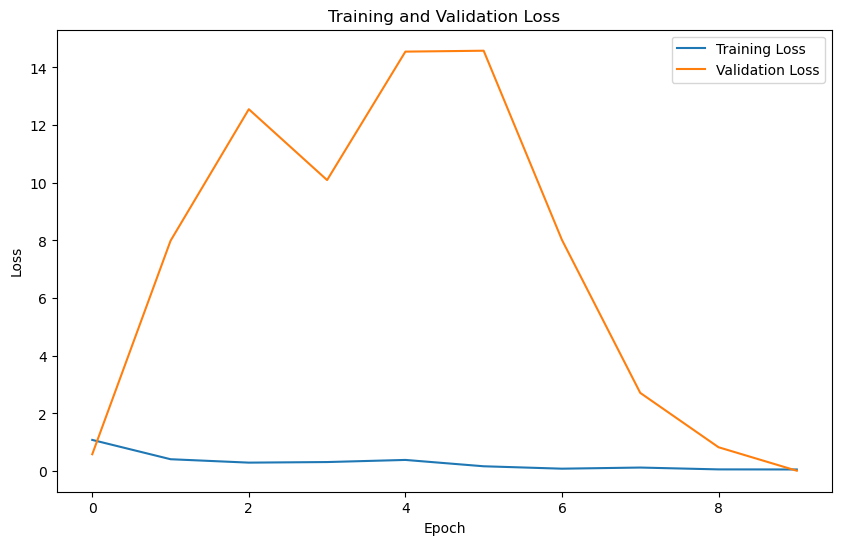

In [66]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

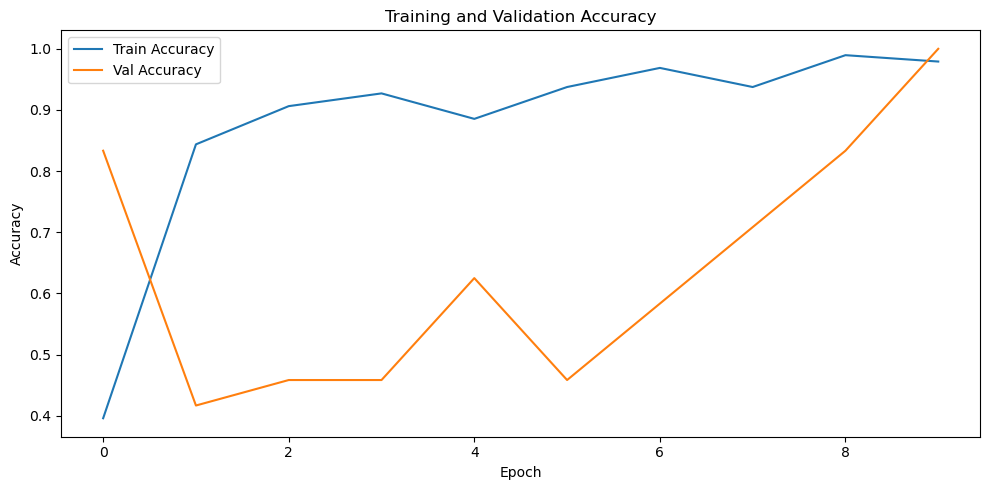

In [67]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))  # smaller figure size
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [68]:
# Load the best model
best_model = models.resnet18(pretrained=True)
best_model.fc = nn.Linear(num_features, 3)  # Output layer with 3 classes
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)

In [69]:
# Generate predictions on validation set
best_model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Generate classification report
target_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=target_names))

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       1.00      1.00      1.00         9
            Leaf smut       1.00      1.00      1.00         9

             accuracy                           1.00        24
            macro avg       1.00      1.00      1.00        24
         weighted avg       1.00      1.00      1.00        24



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

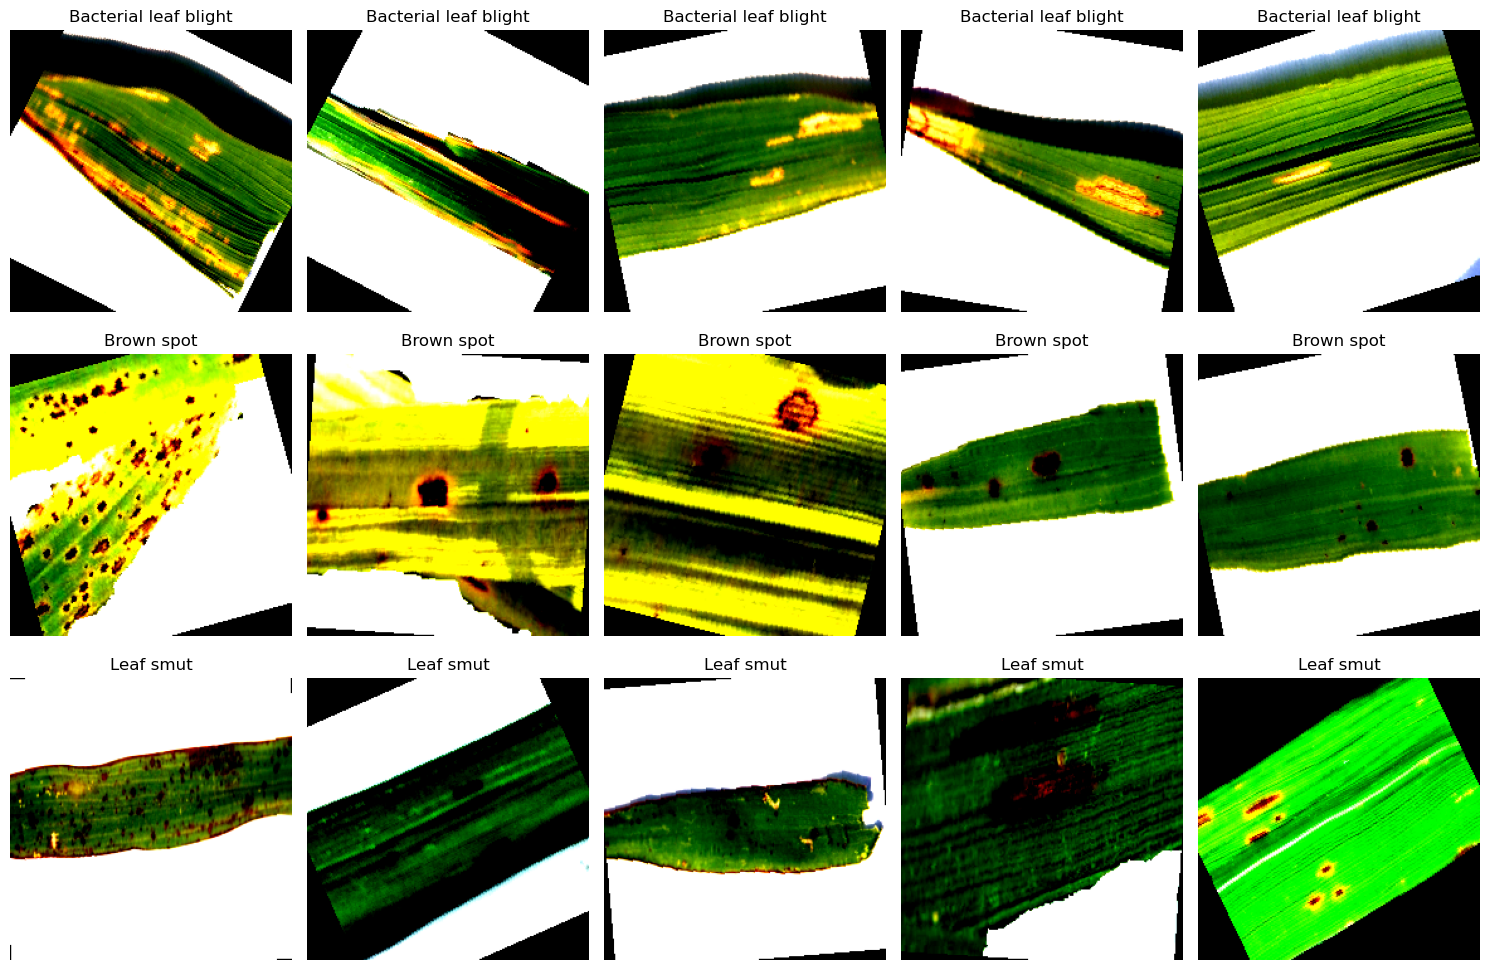

In [70]:
# Visualize 5 images per class
class_names = dataset.classes
num_images_per_class = 5

fig, axes = plt.subplots(3, num_images_per_class, figsize=(15, 10))
for i, class_name in enumerate(class_names):
    class_indices = np.where(np.array(val_labels) == i)[0]
    if len(class_indices) < num_images_per_class:
        num_images = len(class_indices)
    else:
        num_images = num_images_per_class
    sampled_indices = np.random.choice(class_indices, num_images, replace=False)
    for j, idx in enumerate(sampled_indices):
        image, _ = val_dataset[idx]
        image = image.permute(1, 2, 0).cpu().numpy()
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_names[i])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


# Model 2: Using a Pretrained Model resnet18 and tea sickness dataset Dataset

In [10]:
import torch
import warnings
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



# Suppress deprecated warnings from torchvision
warnings.filterwarnings("ignore", category=UserWarning)


In [11]:


# Define data transformation pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.RandomRotation(degrees=30),  # Apply random rotation
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomVerticalFlip(),  # Apply random vertical flip
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Apply random affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Define dataset
dataset = datasets.ImageFolder(root='tea sickness dataset', transform=data_transform)

# Define dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [12]:
# Define data transformation pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='tea sickness dataset', transform=data_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Define the model architecture
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 15)  # Output layer with 3 classes

In [14]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images);k
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {100*train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_accuracy:.2f}%")
    
    # Save losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model55.pth')


Epoch 1/10, Train Loss: 1.0159, Train Acc: 65.54%, Val Loss: 11.1332, Val Acc: 22.60%
Epoch 2/10, Train Loss: 0.8546, Train Acc: 70.48%, Val Loss: 1.4653, Val Acc: 65.54%
Epoch 3/10, Train Loss: 0.6383, Train Acc: 73.73%, Val Loss: 0.8512, Val Acc: 71.75%
Epoch 4/10, Train Loss: 0.6190, Train Acc: 82.06%, Val Loss: 1.4420, Val Acc: 65.54%
Epoch 5/10, Train Loss: 0.5698, Train Acc: 77.12%, Val Loss: 1.4018, Val Acc: 57.63%
Epoch 6/10, Train Loss: 0.7063, Train Acc: 79.80%, Val Loss: 2.3476, Val Acc: 45.20%
Epoch 7/10, Train Loss: 0.7204, Train Acc: 72.60%, Val Loss: 1.7104, Val Acc: 58.19%
Epoch 8/10, Train Loss: 0.5638, Train Acc: 77.97%, Val Loss: 0.7500, Val Acc: 75.14%
Epoch 9/10, Train Loss: 0.4311, Train Acc: 82.63%, Val Loss: 3.0293, Val Acc: 53.11%
Epoch 10/10, Train Loss: 0.4516, Train Acc: 84.18%, Val Loss: 1.2732, Val Acc: 61.58%


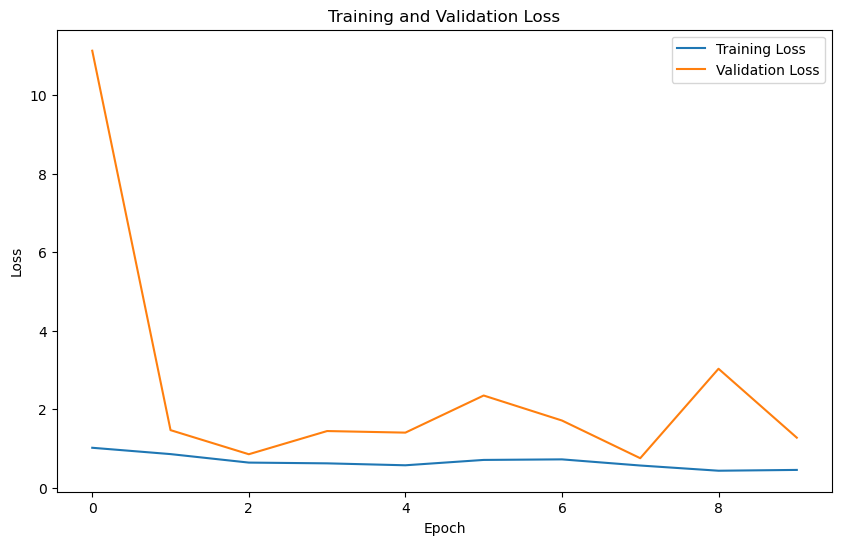

In [15]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

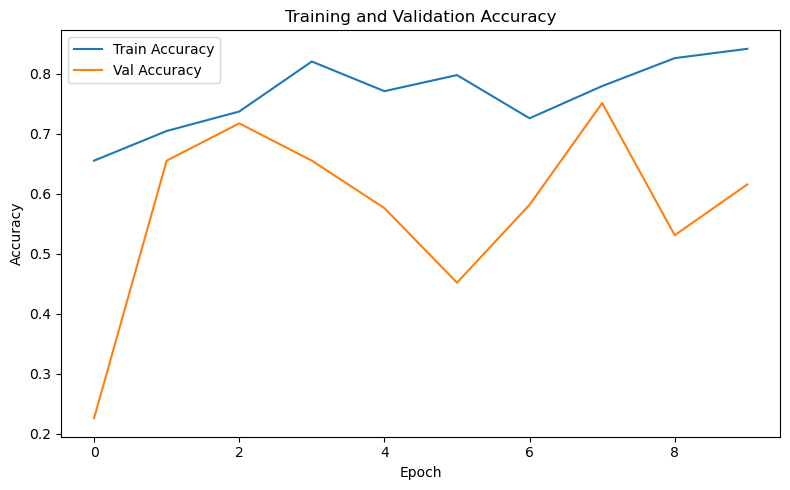

In [22]:
# Plot training and validation accuracies
plt.figure(figsize=(8, 5))  # smaller figure size
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [21]:
# Generate predictions on validation set
model.eval()  # Assuming 'model' is the variable where you stored the best model
val_preds = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Change 'best_model155' to 'model'
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Generate classification report
target_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=target_names))


Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.50      0.22      0.31        18
   algal leaf       0.65      0.92      0.76        26
bird eye spot       1.00      0.10      0.17        21
 brown blight       1.00      0.17      0.29        24
   gray light       0.37      1.00      0.54        17
      healthy       1.00      1.00      1.00        15
red leaf spot       0.87      0.96      0.91        27
   white spot       0.51      0.62      0.56        29

     accuracy                           0.62       177
    macro avg       0.74      0.62      0.57       177
 weighted avg       0.74      0.62      0.57       177



# Model 3:  Using CNN Mininetwork Architecture with tea sickness Dataset

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [20]:
# Define data transformation pipeline
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='tea sickness dataset', transform=data_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 8)  # Output layer with 8 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN model
model = CNN()


In [26]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {100*train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_accuracy:.2f}%")
    
    # Save losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/10, Train Loss: 1.3184, Train Acc: 42.51%, Val Loss: 1.0989, Val Acc: 53.67%
Epoch 2/10, Train Loss: 1.0536, Train Acc: 53.95%, Val Loss: 0.9392, Val Acc: 65.54%
Epoch 3/10, Train Loss: 0.8816, Train Acc: 64.12%, Val Loss: 0.7826, Val Acc: 67.80%
Epoch 4/10, Train Loss: 0.8645, Train Acc: 66.67%, Val Loss: 0.6517, Val Acc: 71.19%
Epoch 5/10, Train Loss: 0.8006, Train Acc: 64.69%, Val Loss: 0.7329, Val Acc: 68.93%
Epoch 6/10, Train Loss: 0.6835, Train Acc: 70.62%, Val Loss: 0.8058, Val Acc: 64.41%
Epoch 7/10, Train Loss: 0.6334, Train Acc: 70.76%, Val Loss: 0.5909, Val Acc: 76.27%
Epoch 8/10, Train Loss: 0.5845, Train Acc: 76.55%, Val Loss: 0.9281, Val Acc: 63.28%
Epoch 9/10, Train Loss: 0.7623, Train Acc: 66.38%, Val Loss: 0.5728, Val Acc: 77.40%
Epoch 10/10, Train Loss: 0.5975, Train Acc: 75.71%, Val Loss: 0.6380, Val Acc: 71.75%


In [27]:
# Load the best model
best_model = CNN()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)

# Generate predictions on validation set
best_model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


In [28]:

# Generate classification report
target_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.70      0.50      0.58        14
   algal leaf       0.77      0.92      0.84        26
bird eye spot       0.92      0.42      0.58        26
 brown blight       0.67      0.62      0.65        16
   gray light       0.50      1.00      0.67        17
      healthy       1.00      1.00      1.00        20
red leaf spot       0.90      0.96      0.93        28
   white spot       0.80      0.67      0.73        30

     accuracy                           0.77       177
    macro avg       0.78      0.76      0.75       177
 weighted avg       0.80      0.77      0.76       177



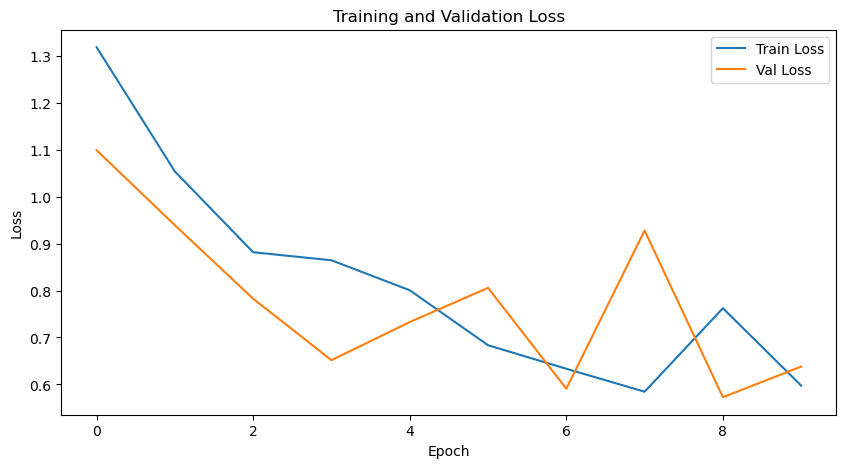

In [29]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

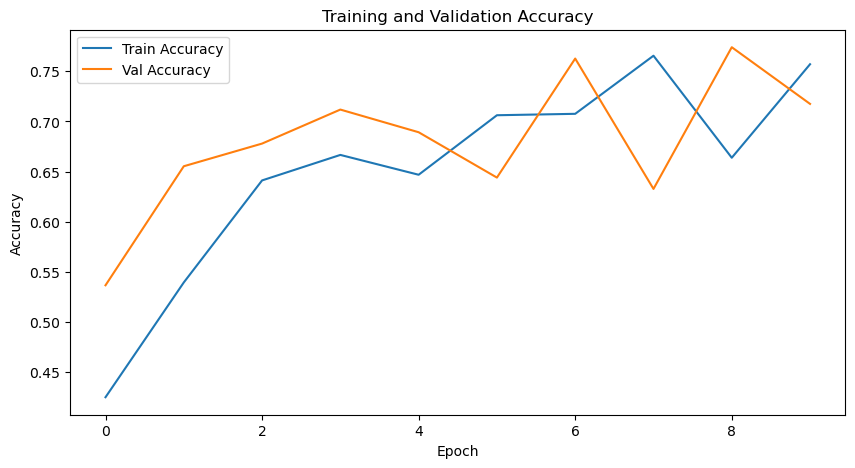

In [30]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

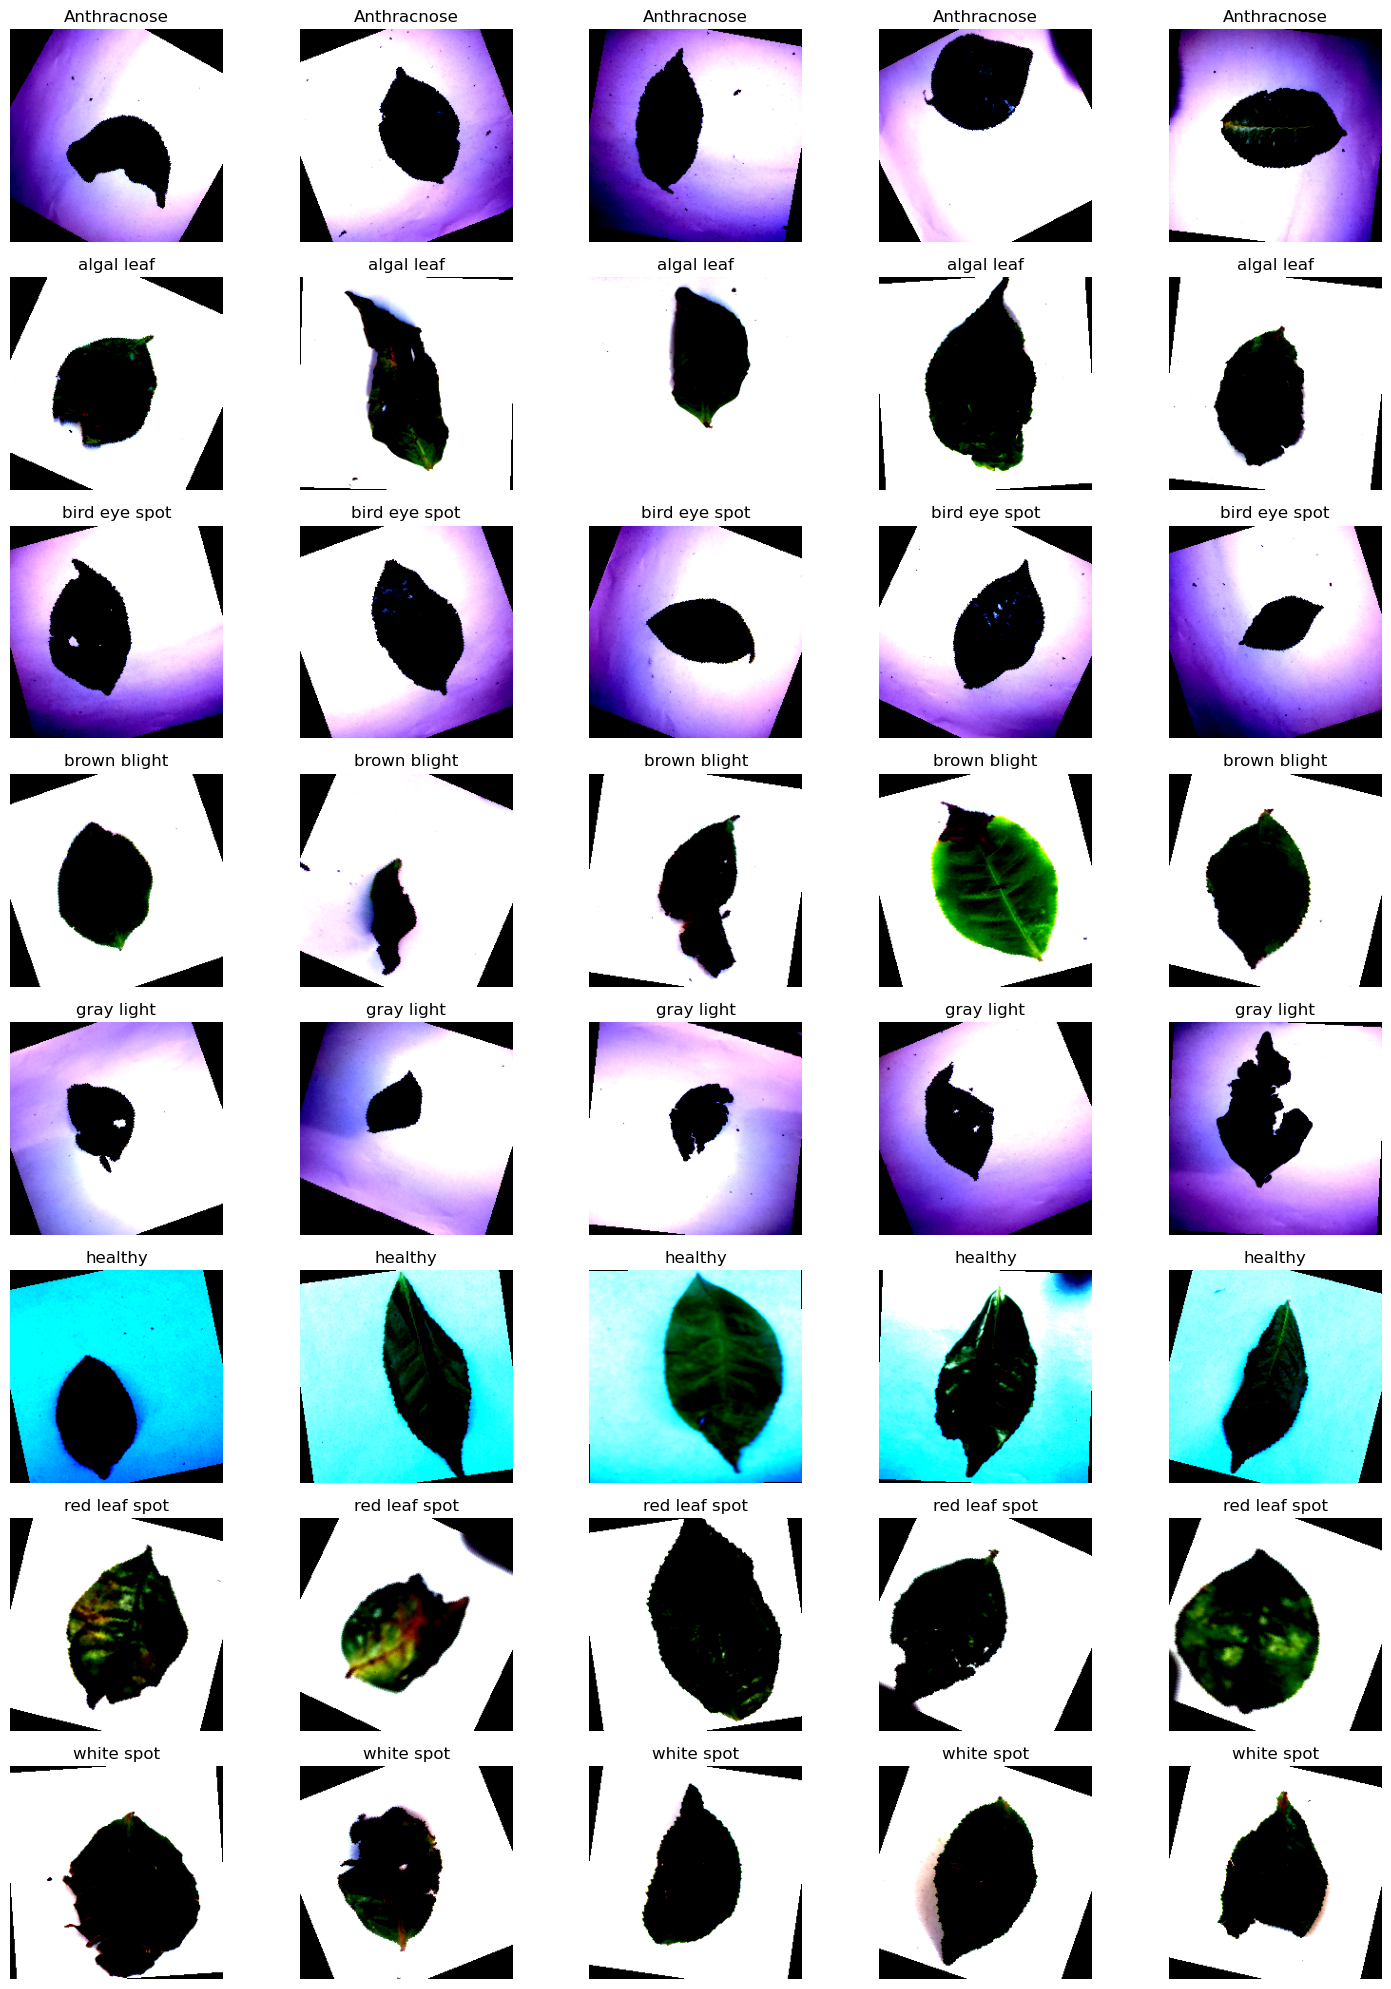

In [31]:
# Visualize 5 images per class
class_names = dataset.classes
num_images_per_class = 5

fig, axes = plt.subplots(8, num_images_per_class, figsize=(15, 20))
for i, class_name in enumerate(class_names):
    class_indices = np.where(np.array(val_labels) == i)[0]
    sampled_indices = np.random.choice(class_indices, num_images_per_class, replace=False)
    for j, idx in enumerate(sampled_indices):
        image, _ = val_dataset[idx]
        image = image.permute(1, 2, 0).cpu().numpy()
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_names[i])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Model 4: Using CNN Mininetwork Architecture with rice_leaf_diseases

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [24]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder(root='rice_leaf_diseases', transform=data_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 8)  # Output layer with 8 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN model
model = CNN()


In [26]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {100*train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_accuracy:.2f}%")
    
    # Save losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model67.pth')


Epoch 1/10, Train Loss: 3.7668, Train Acc: 25.00%, Val Loss: 3.1786, Val Acc: 41.67%
Epoch 2/10, Train Loss: 2.2500, Train Acc: 31.25%, Val Loss: 1.6443, Val Acc: 41.67%
Epoch 3/10, Train Loss: 1.4228, Train Acc: 31.25%, Val Loss: 1.1513, Val Acc: 41.67%
Epoch 4/10, Train Loss: 1.1334, Train Acc: 40.62%, Val Loss: 1.1483, Val Acc: 25.00%
Epoch 5/10, Train Loss: 0.9433, Train Acc: 52.08%, Val Loss: 0.9861, Val Acc: 45.83%
Epoch 6/10, Train Loss: 0.9250, Train Acc: 59.38%, Val Loss: 0.9540, Val Acc: 41.67%
Epoch 7/10, Train Loss: 0.8371, Train Acc: 63.54%, Val Loss: 0.9353, Val Acc: 54.17%
Epoch 8/10, Train Loss: 0.8120, Train Acc: 62.50%, Val Loss: 0.8460, Val Acc: 50.00%
Epoch 9/10, Train Loss: 0.7835, Train Acc: 61.46%, Val Loss: 0.9094, Val Acc: 45.83%
Epoch 10/10, Train Loss: 0.7494, Train Acc: 64.58%, Val Loss: 0.9544, Val Acc: 41.67%


In [27]:
# Load the best model
best_model = CNN()
best_model.load_state_dict(torch.load('best_model67.pth'))
best_model = best_model.to(device)

# Generate predictions on validation set
best_model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


In [28]:
# Generate classification report
target_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=target_names))

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.35      0.86      0.50         7
           Brown spot       1.00      0.50      0.67        10
            Leaf smut       0.50      0.14      0.22         7

             accuracy                           0.50        24
            macro avg       0.62      0.50      0.46        24
         weighted avg       0.67      0.50      0.49        24



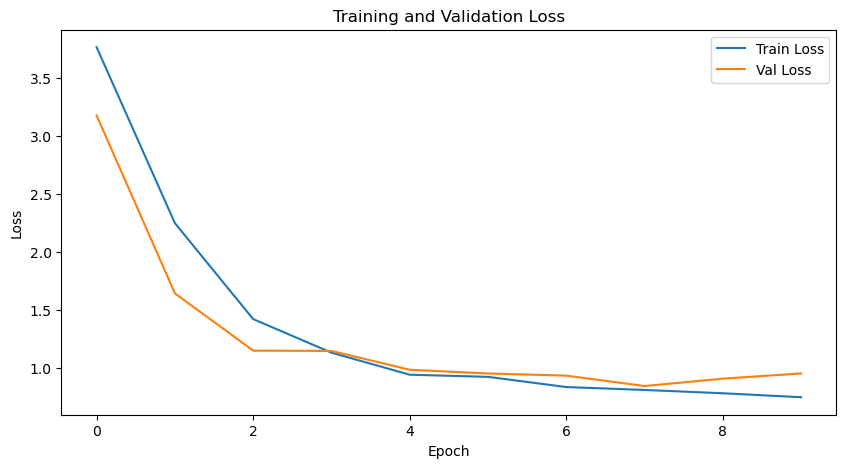

In [29]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

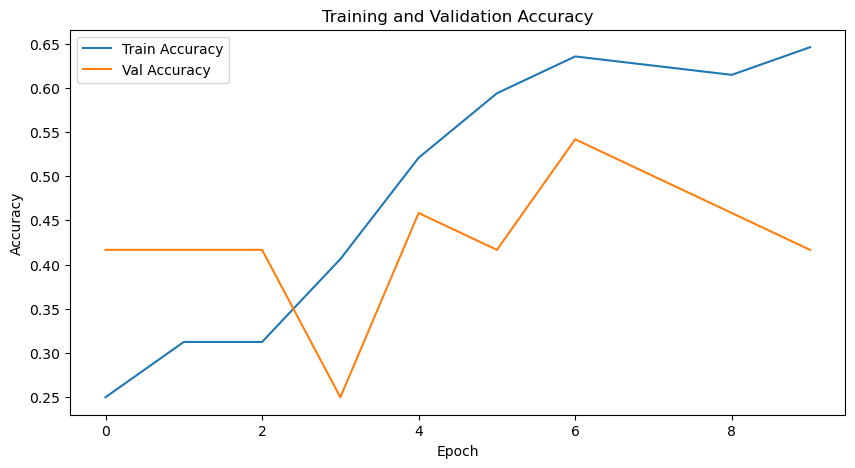

In [30]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Model Comparison

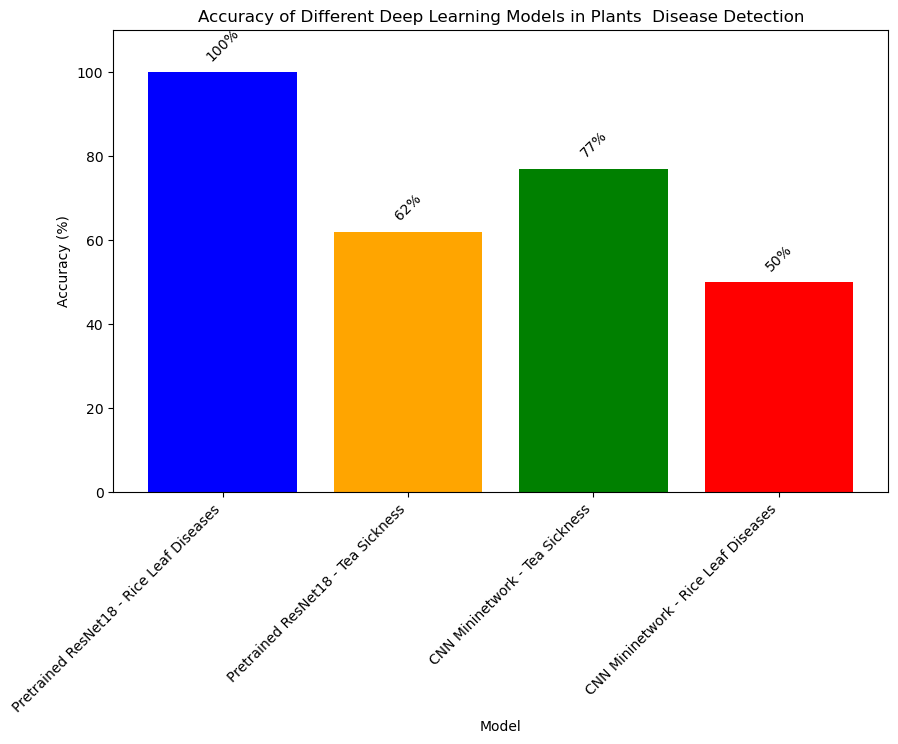

In [2]:
import matplotlib.pyplot as plt

# Model names
models = ['Pretrained ResNet18 - Rice Leaf Diseases', 
          'Pretrained ResNet18 - Tea Sickness', 
          'CNN Mininetwork - Tea Sickness', 
          'CNN Mininetwork - Rice Leaf Diseases']

# Accuracy values
accuracies = [100, 62, 77, 50]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])

plt.title('Accuracy of Different Deep Learning Models in Plants  Disease Detection')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

plt.ylim(0, 110)  # Set y-axis limit to ensure visibility of percentages

# Adding the accuracy values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{accuracies[i]}%", 
             ha='center', va='bottom', rotation=45)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

plt.show()


# Deployment 

In [1]:
import torch
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image

import warnings
warnings.filterwarnings("ignore")


# Load the ResNet model
model = resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3)  # Replace 3 with the number of output classes

# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define data transformation pipeline for inference
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare input data
input_image_path = 'DSC_0100.jpg'
input_image = Image.open(input_image_path)
input_tensor = data_transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Model inference
with torch.no_grad():
    output = model(input_batch)

# Post-process predictions (if needed)
predicted_class = torch.argmax(output, dim=1).item()

# Convert class index to class label
class_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
predicted_label = class_labels[predicted_class]


print("Predicted Disease:", predicted_label)


Predicted Disease: Brown spot


In [2]:
import torch
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import gradio as gr

import warnings
warnings.filterwarnings("ignore")

# Load the ResNet model
model = resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3) 

# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define data transformation pipeline for inference
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define function for model inference
def predict_disease(image):
    # Convert Gradio Image object to PIL Image
    input_image = Image.fromarray(image.astype('uint8'), 'RGB')
    input_tensor = data_transform(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        output = model(input_batch)

    # Post-process predictions
    predicted_class = torch.argmax(output, dim=1).item()

    # Convert class index to class label
    class_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Create Gradio interface
iface = gr.Interface(
    fn=predict_disease,
    inputs="image",
    outputs="text",
    title="Plant Disease Classification",
    description="Upload an image of a plant leaf to classify the disease."
)

# Launch the Gradio interface
iface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
